In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import glob
from tqdm import tqdm

import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
plt.style.use('seaborn-whitegrid')
sns.set_style("white",rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1

## Data
See data availability

In [2]:
polygons = # array of strings, names of departments in the country

Rij_vec = # Array of matrices, each matrix being the reconstructed reproduction operator in a certain interval of time. Nodes have polygons' order.

calendar = # Dates associated to the entries of Rij_vec. The first entry of calendar corresponds to the date of the first entry of Rij_vec

pop_vec = # Array of populations, nodes have polygons' order. 

tot_pop = np.sum(pop_vec)

N = len(polygons)

## SEIIR model

In [6]:
params={'beta': 0.00068/9.1, 'mu': 1/(7+2.1), 'beta_I' : 0.51, 'epsilon' : 1/3.7, 'p_sc' : 0.32}
delta_T=1
N0=pop_vec
a=np.where(calendar=='2021-02-02')[0][0]
R_interval=[Rij_vec[a-1],Rij_vec[a],Rij_vec[a+1],Rij_vec[a+2]]
Q_2021_02_02=np.mean(R_interval,0)
def SEIIR_model (I0, E0=np.zeros(len(polygons)), R0=np.zeros(len(polygons)), T=7*len(Rij_vec),Q=Q_2021_02_02, pars=params):
    
    S=np.zeros((T+1,len(polygons)))
    E=np.zeros((T+1,len(polygons)))
    I_sc=np.zeros((T+1,len(polygons)))
    I_c=np.zeros((T+1,len(polygons)))
    R=np.zeros((T+1,len(polygons)))
    I_inc=np.zeros((T+1,len(polygons)))
    N=N0.copy()
    #present time variables
    Et=E0.copy()
    It_sc=(I0*pars['p_sc']).astype(int)
    It_c=I0-It_sc
    Rt=R0.copy()
    St=N-Rt-It_sc-It_c
    
    E[0]=Et.copy()
    I_sc[0]=It_sc.copy()
    I_c[0]=It_c.copy()
    R[0]=Rt.copy()
    S[0]=St.copy()
    I_inc[0]=It_sc+It_c
    
    p_mu=1-np.exp(-pars['mu']*delta_T)
    p_beta=1-np.exp(-pars['beta']*delta_T)
    p_beta_I=1-np.exp(-pars['beta']*pars['beta_I']*delta_T)
    p_epsilon=1-np.exp(-pars['epsilon']*delta_T)
    
    for t in range(T):
        for i in range(len(polygons)):
            
            R_sc_new=np.random.binomial(n=It_sc[i], p=p_mu)
            It_sc[i]-=R_sc_new
            R_c_new=np.random.binomial(n=It_c[i], p=p_mu)
            It_c[i]-=R_c_new
            Rt[i]+=(R_sc_new+R_c_new)
            
            I_sc_new=np.random.binomial(n=Et[i],p=p_epsilon*pars['p_sc'])
            Et[i]-=I_sc_new
            It_sc[i]+=I_sc_new
            I_c_new=np.random.binomial(n=Et[i],p=p_epsilon*(1-pars['p_sc']))
            It_c[i]+=I_c_new
            Et[i]-=I_c_new
            I_inc[t+1][i]=I_sc_new+I_c_new
            
            proba_beta=np.dot( Q[:,i],(p_beta_I*It_sc[:]+p_beta*It_c[:])/N[:] )
            E_new=np.random.binomial(n=St[i], p=proba_beta)
            Et[i]+=E_new
            
        St=N-Rt-It_sc-It_c-Et
        E[t+1]=Et.copy()
        I_sc[t+1]=It_sc.copy()
        I_c[t+1]=It_c.copy()
        R[t+1]=Rt.copy()
        S[t+1]=St.copy()
    return ([S,E,I_sc,I_c,R,I_inc])

## Algebra

In [8]:
Rfrance=1.5
beta=Rfrance*params['mu']/(np.sort(np.linalg.eig(Q_2021_02_02)[0])[-1]*(1-params['p_sc']+params['beta_I']*params['p_sc']))
print (beta)
params['beta']=beta
eff_beta=params['beta']*(np.sort(np.linalg.eig(Q_2021_02_02)[0])[-1]*(1-params['p_sc']+params['beta_I']*params['p_sc']))
print(eff_beta)
over_beta=params['beta']*(np.sort(np.linalg.eig(Q_2021_02_02)[0])[-1])
print(over_beta)

7.409082406593604e-05
0.16483516483516483
0.1954876243301291


In [9]:
w,vl,vr=scipy.linalg.eig(Q_2021_02_02,left=True)
v=[]
z=[]
for u,wu in enumerate (w):
    v.append(vr[:,u]/np.sum(vr[:,u]))
    z.append(vl[:,u]/np.sum(vl[:,u]))
v=np.array(v)
z=np.array(z)
max_v=v[w.argmax()] 
max_z=z[w.argmax()]
projectors=np.array([[[v[alpha][j]*z[alpha][k] for k in range(N)] for j in range(N)] for alpha in range(N)])

#-----------------------------------------------------------------

for i in range (1,10):
    if(max_v[0]<0):
        v[np.argsort(w)[-i]]*=(-1)
    if(max_z[0]<0):
        z[np.argsort(w)[-i]]*=(-1)
    v_rank=v[np.argsort(w)[-i]]
    print(polygons.iloc[v_rank.argmax()],np.sort(w)[-i])
print('-')
for i in range (1,10):
    print(polygons.iloc[np.argsort(max_v)[-i]],np.sort(max_v)[-i])

Paris (2638.486301031795+0j)
Alpes-Maritimes (1619.7209571814255+0j)
Hauts-de-Seine (1468.282860878924+0j)
Rhône (1342.9748778329238+0j)
Bouches-du-Rhône (1209.9070470804963+0j)
Seine-Saint-Denis (1070.4240842021575+0j)
Val-de-Marne (998.481629137559+0j)
Val-d'Oise (954.9537039827381+0j)
Var (850.7613926802685+0j)
-
Paris 0.6187106968503224
Hauts-de-Seine 0.10709834476249662
Seine-Saint-Denis 0.09158953188934467
Val-de-Marne 0.06054107246019619
Val-d'Oise 0.035879144646901284
Essonne 0.023547913356975984
Yvelines 0.02311975177280934
Seine-et-Marne 0.018628095159668876
Oise 0.003250726308339194


## Simulation

In [10]:
Bordeaux=np.where(polygons=='Gironde')[0][0]
HDS=np.where(polygons=='Hauts-de-Seine')[0][0]
AM=np.where(polygons=='Alpes-Maritimes')[0][0]
PARIS=np.where(polygons=='Paris')[0][0]

HDS_0,AM_0,PARIS_0=np.zeros(N),np.zeros(N),np.zeros(N)
HDS_0[HDS]=100
AM_0[AM]=100
PARIS_0[PARIS]=100

pop_like_0=np.array([round(100*(np.array(pop_vec)/np.sum(pop_vec))[i]) for i in range (N)])
np.sum(pop_like_0)

99

In [11]:
params['beta']=beta#0.00068/9.1

I_0=np.zeros((2,N))
#I_0[0]=np.array(pop_like_0)
#I_0[1]=np.array(HDS_0)
I_0[0]=np.array(PARIS_0)
I_0[1]=np.array(pop_like_0)
E_0=I_0.copy()
n=1000

SOL_panel_check=np.zeros((2,n,6,2*len(Rij_vec)+1,N))
for y,Y in enumerate (I_0):
    I0_=Y.copy()
    E0_=Y.copy()
    for s in tqdm(range(n)):
        SOL_panel_check[y][s]=(np.array(SEIIR_model(I0_,E0=E0_,Q=Q_2021_02_02,T=2*len(Rij_vec))))
SOL_panel_check=np.array(SOL_panel_check)

100%|██████████| 1000/1000 [20:50<00:00,  1.25s/it]


In [12]:
with open('C:/Users/piero/Documents/PHD/eugenio/Fig1_SOL_1k.csv', 'wb') as f:
    np.save(f, SOL_panel_check)

In [11]:
with open('C:/Users/piero/Documents/PHD/eugenio/SIMULS/Fig1_SOL_1k.csv', 'rb') as f:
    SOL_panel_check = np.load(f)

## Reproductive Numbers

In [14]:
d_print = [[np.sum(SOL_panel_check[ic,r,5],axis=1)[t],ic,r,t] for ic in range(len(SOL_panel_check)) for r in range(len(SOL_panel_check[0])) for t in range(len(SOL_panel_check[0,0,0]))] 
df_print = pd.DataFrame(data=d_print,columns=['incidence','IC','run','time'])
display(df_print[:4])
df_print.to_csv('C:/Users/piero/Documents/PHD/eugenio/Fig1_inc.csv',sep=',')

,incidence,IC,run,time
0,100.0,0,0,0
1,22.0,0,0,1
2,18.0,0,0,2
3,23.0,0,0,3


In [15]:
d_print_zproj = [[len(polygons)*np.dot(SOL_panel_check[ic,r,5,t],max_z),ic,r,t] for ic in range(len(SOL_panel_check)) for r in range(len(SOL_panel_check[0])) for t in range(len(SOL_panel_check[0,0,0]))] 
df_print_zproj = pd.DataFrame(data=d_print_zproj,columns=['incidence','IC','run','time'])
display(df_print_zproj[:4])
df_print_zproj.to_csv('C:/Users/piero/Documents/PHD/eugenio/Fig1_inc_zproj.csv',sep=',')

,incidence,IC,run,time
0,4937.920326,0,0,0
1,1086.342472,0,0,1
2,888.825659,0,0,2
3,1057.010536,0,0,3


In [12]:
def s_calc_proj (SOL,Rij=Q_2021_02_02):
    s_=np.zeros((len(SOL),len(SOL[0]),len(SOL[0][0][0]),len(SOL[0][0][0][0])))
    S_=np.zeros((len(SOL),len(SOL[0]),len(SOL[0][0][0])))
    S_zproj_=np.zeros((len(SOL),len(SOL[0]),len(SOL[0][0][0])))
    for ic in tqdm(range (len(SOL))):
        for run in range (len(SOL[0])):
            for t in range (len(SOL[0][0][0])):
                a=SOL[ic][run][2][t]+SOL[ic][run][3][t]
                b=np.sum(SOL[ic][run][2][t]+SOL[ic][run][3][t],axis=0)
                b_second=np.dot(SOL[ic][run][2][t]+SOL[ic][run][3][t],max_z)
                c=np.divide(a, b, out=np.zeros_like(a), where=b!=0)
                c_second=np.divide(a, b_second, out=np.zeros_like(a), where=b_second!=0)
                sS=np.sum((Rij*(np.array([SOL[ic,run,0,t]*c/pop_vec]*len(polygons)))) ,axis=1)
                sS_second=np.sum((Rij*(np.array([SOL[ic,run,0,t]*c_second/pop_vec]*len(polygons)))) ,axis=1)
                s_[ic,run,t]=np.divide(sS,c,out=np.zeros_like(sS),where=c!=0)
                S_[ic,run,t]=np.sum(sS,axis=0)
                S_zproj_[ic,run,t]=np.dot(sS_second,max_z)
    return [s_,S_,S_zproj_]

s_S = s_calc_proj(SOL_panel_check)
s_check=np.array(s_S[0])
S_check=np.array(s_S[1])
S_zproj_check=np.array(s_S[2])

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [02:55<00:00, 87.75s/it]


In [17]:
def ws_calc (SOL,Q=Q_2021_02_02):
    max_ws=[[[np.amax(np.linalg.eig(Q*(np.array([SOL[ic,run,0,t]/pop_vec]*len(polygons))))[0]) for t in range (len(SOL[0][0][0]))]for run in range (len(SOL[0]))]for ic in tqdm(range(len(SOL)))]
    return (max_ws)

max_w=ws_calc(SOL_panel_check)

100%|██████████| 2/2 [30:14<00:00, 907.41s/it]


In [18]:
with open('C:/Users/piero/Documents/PHD/eugenio/maxw_Fig1_1k.csv', 'wb') as f:
    np.save(f, max_w)

In [13]:
with open('C:/Users/piero/Documents/PHD/eugenio/SIMULS/maxw_Fig1_1k.csv', 'rb') as f:
    max_w = np.load(f)

In [14]:
S_df_check = pd.read_csv('C:/Users/piero/Documents/PHD/eugenio/SIMULS/Fig1_epiS.csv',sep=',',engine='python')
S_df_check_zproj = pd.read_csv('C:/Users/piero/Documents/PHD/eugenio/SIMULS/Fig1_epiS_zproj.csv',sep=',',engine='python')
display(S_df_check[:5])

,S,IC,run,time
0,NaN,0,0,0
1,NaN,0,0,1
2,NaN,0,0,2
3,NaN,0,0,3
4,1.787229,0,0,4


In [15]:
S_epi_check=np.zeros((len(S_check),len(S_check[0]),174))
S_epi_check_zproj=np.zeros((len(S_check),len(S_check[0]),174))
for ic in range(len(S_check)):
    for r in range(len(S_check[0])):
        a=S_df_check[S_df_check['IC']==ic]
        a_zproj=S_df_check_zproj[S_df_check_zproj['IC']==ic]
        S_epi_check[ic][r]=a[a['run']==r].iloc[:,0]
        S_epi_check_zproj[ic][r]=a_zproj[a_zproj['run']==r].iloc[:,0]

## Figures

In [16]:
def S_panel_plotter_Fig1(S,S_Epi,s,dim1=2,dim2=2,max_w_=max_w,end=[150,150],start=0,save=False,name='a',tit=None):
    
    fig,ax = plt.subplots(dim1,dim2,figsize=(16,9),dpi=300)
    #c=['gold','tab:blue','dimgrey','r','orchid','coral']#previous R: dimgrey
    c=['darkorange','tab:blue','dimgrey','r','orchid','coral']
    x=np.linspace(0,len(S[0,0]),len(S[0,0]))
    pref=params['beta']*(1-params['p_sc']+params['beta_I']*params['p_sc'])/params['mu']
    w1=pref*np.amax(np.linalg.eig(Q_2021_02_02)[0])
    fig.suptitle(tit,fontsize=20 )
    sh=14
    cp=sns.color_palette('gray_r',len(polygons))#+25)[:-25]
    #cp=sns.color_palette('Purples',len(polygons))
    cp1=cp[:-25]
    cp2=cp[-25:]
    cp=np.concatenate((cp2,cp1))

    for i,a in enumerate (ax.reshape(-1)[:2]): #(1/(np.linalg.norm(max_v)**2))*
        m=pref*np.percentile(S[i],50,axis=0)
        CI=pref*np.array((np.percentile(S[i],2.5,axis=0),np.percentile(S[i],97.5,axis=0)))
        m_Epi=np.percentile(S_Epi[i],50,axis=0)
        CI_Epi=np.array((np.percentile(S_Epi[i],2.5,axis=0),np.percentile(S_Epi[i],97.5,axis=0)))
        mw=pref*np.percentile(max_w_[i],50,axis=0)
        CIw=pref*np.array((np.percentile(max_w_[i],2.5,axis=0),np.percentile(max_w_[i],97.5,axis=0)))
        a.axhline(1,0,1,color=c[2],linestyle='dashed',alpha=1)#,label=r'$\mathcal{R}_0=r[Q_0]$')
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0])
        a.fill_between(x[start:end[i]],CIw[0][start:end[i]],CIw[1][start:end[i]], color=c[0],alpha=.3)
        a.plot(x[start:end[i]],m[start:end[i]],label=r'$S$',color=c[3])
        a.fill_between(x[start:end[i]],CI[0][start:end[i]],CI[1][start:end[i]], color=c[3],alpha=.3)
        a.plot(x[start+sh:end[i]],m_Epi[start+(sh-5):end[i]-5],label='EpiEstim',color=c[4])
        a.fill_between(x[start+sh:end[i]],CI_Epi[0][start+(sh-5):end[i]-5],CI_Epi[1][start+(sh-5):end[i]-5], color=c[4],alpha=.3)
        a.tick_params(axis='x', labelsize=0)
        if i==1:
            a.tick_params(axis='y',labelsize=0)
        else:
            a.tick_params(axis='y',labelsize=15)
        #a.grid(alpha=.7,axis='x')
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        
    handles, labels = a.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=1,bbox_to_anchor=(0.975, 0.95),bbox_transform=fig.transFigure, frameon=True,fontsize=15)#0.975,0.449/0.485/0.262
        
    for i,a in enumerate (ax.reshape(-1)[2:]): 
        m=(pref*np.percentile(s[i],50,axis=0))
        m=np.where(m==0,np.nan,m)
        mw=(pref*np.percentile(max_w_[i],50,axis=0))
        CIw=(pref*np.array((np.percentile(max_w_[i],2.5,axis=0),np.percentile(max_w_[i],97.5,axis=0))))
        order=(np.argsort(max_v))
        #ordered_cp=[cp[j] for j in order]
        #a.set_prop_cycle('color',sns.color_palette('copper',len(polygons)))
        a.set_prop_cycle('color',cp)
        #for dp in range (len(polygons))
        a.axhline(1,0,1,color='dimgrey',linestyle='dashed',alpha=1)
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0],alpha=1)#linewidth=3
        a.axhline(4,0,1,color='tomato',alpha=1,label=r'$s_i$')
        mT=m.T
        for p in order:
            a.plot(x[start:end[i]],mT[p][start:end[i]],alpha=1)#,color='mediumorchid')#,color=ordered_cp[dp])
        print(len(m[start:end[i],0]))
        #a.set_yscale('log')
        a.tick_params(axis='x',labelsize=15)
        if i==1:
            a.tick_params(axis='y',labelsize=0)
        else:
            a.tick_params(axis='y',labelsize=15)
        #a.grid(alpha=.7,axis='x')
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        a.set_xlabel('Days',fontsize=20)
        
    #fig.supylabel('Values',fontsize=20)
    ax[0][0].set_ylabel('Reproduction ratio',fontsize=20)
    ax[1][0].set_ylabel('Reproduction ratio',fontsize=20)
    handles, labels = a.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=1,bbox_to_anchor=(0.975, 0.495),bbox_transform=fig.transFigure, frameon=True,fontsize=15)#0.975,0.449/0.485/0.262
    fig.tight_layout()
    if (save==True):
        #fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/Fig1/'+str('/')+str(name))
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paper/Figure2.svg',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paper/Figure2.pdf',bbox_inches='tight')

150
150


c:\Users\piero\anaconda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


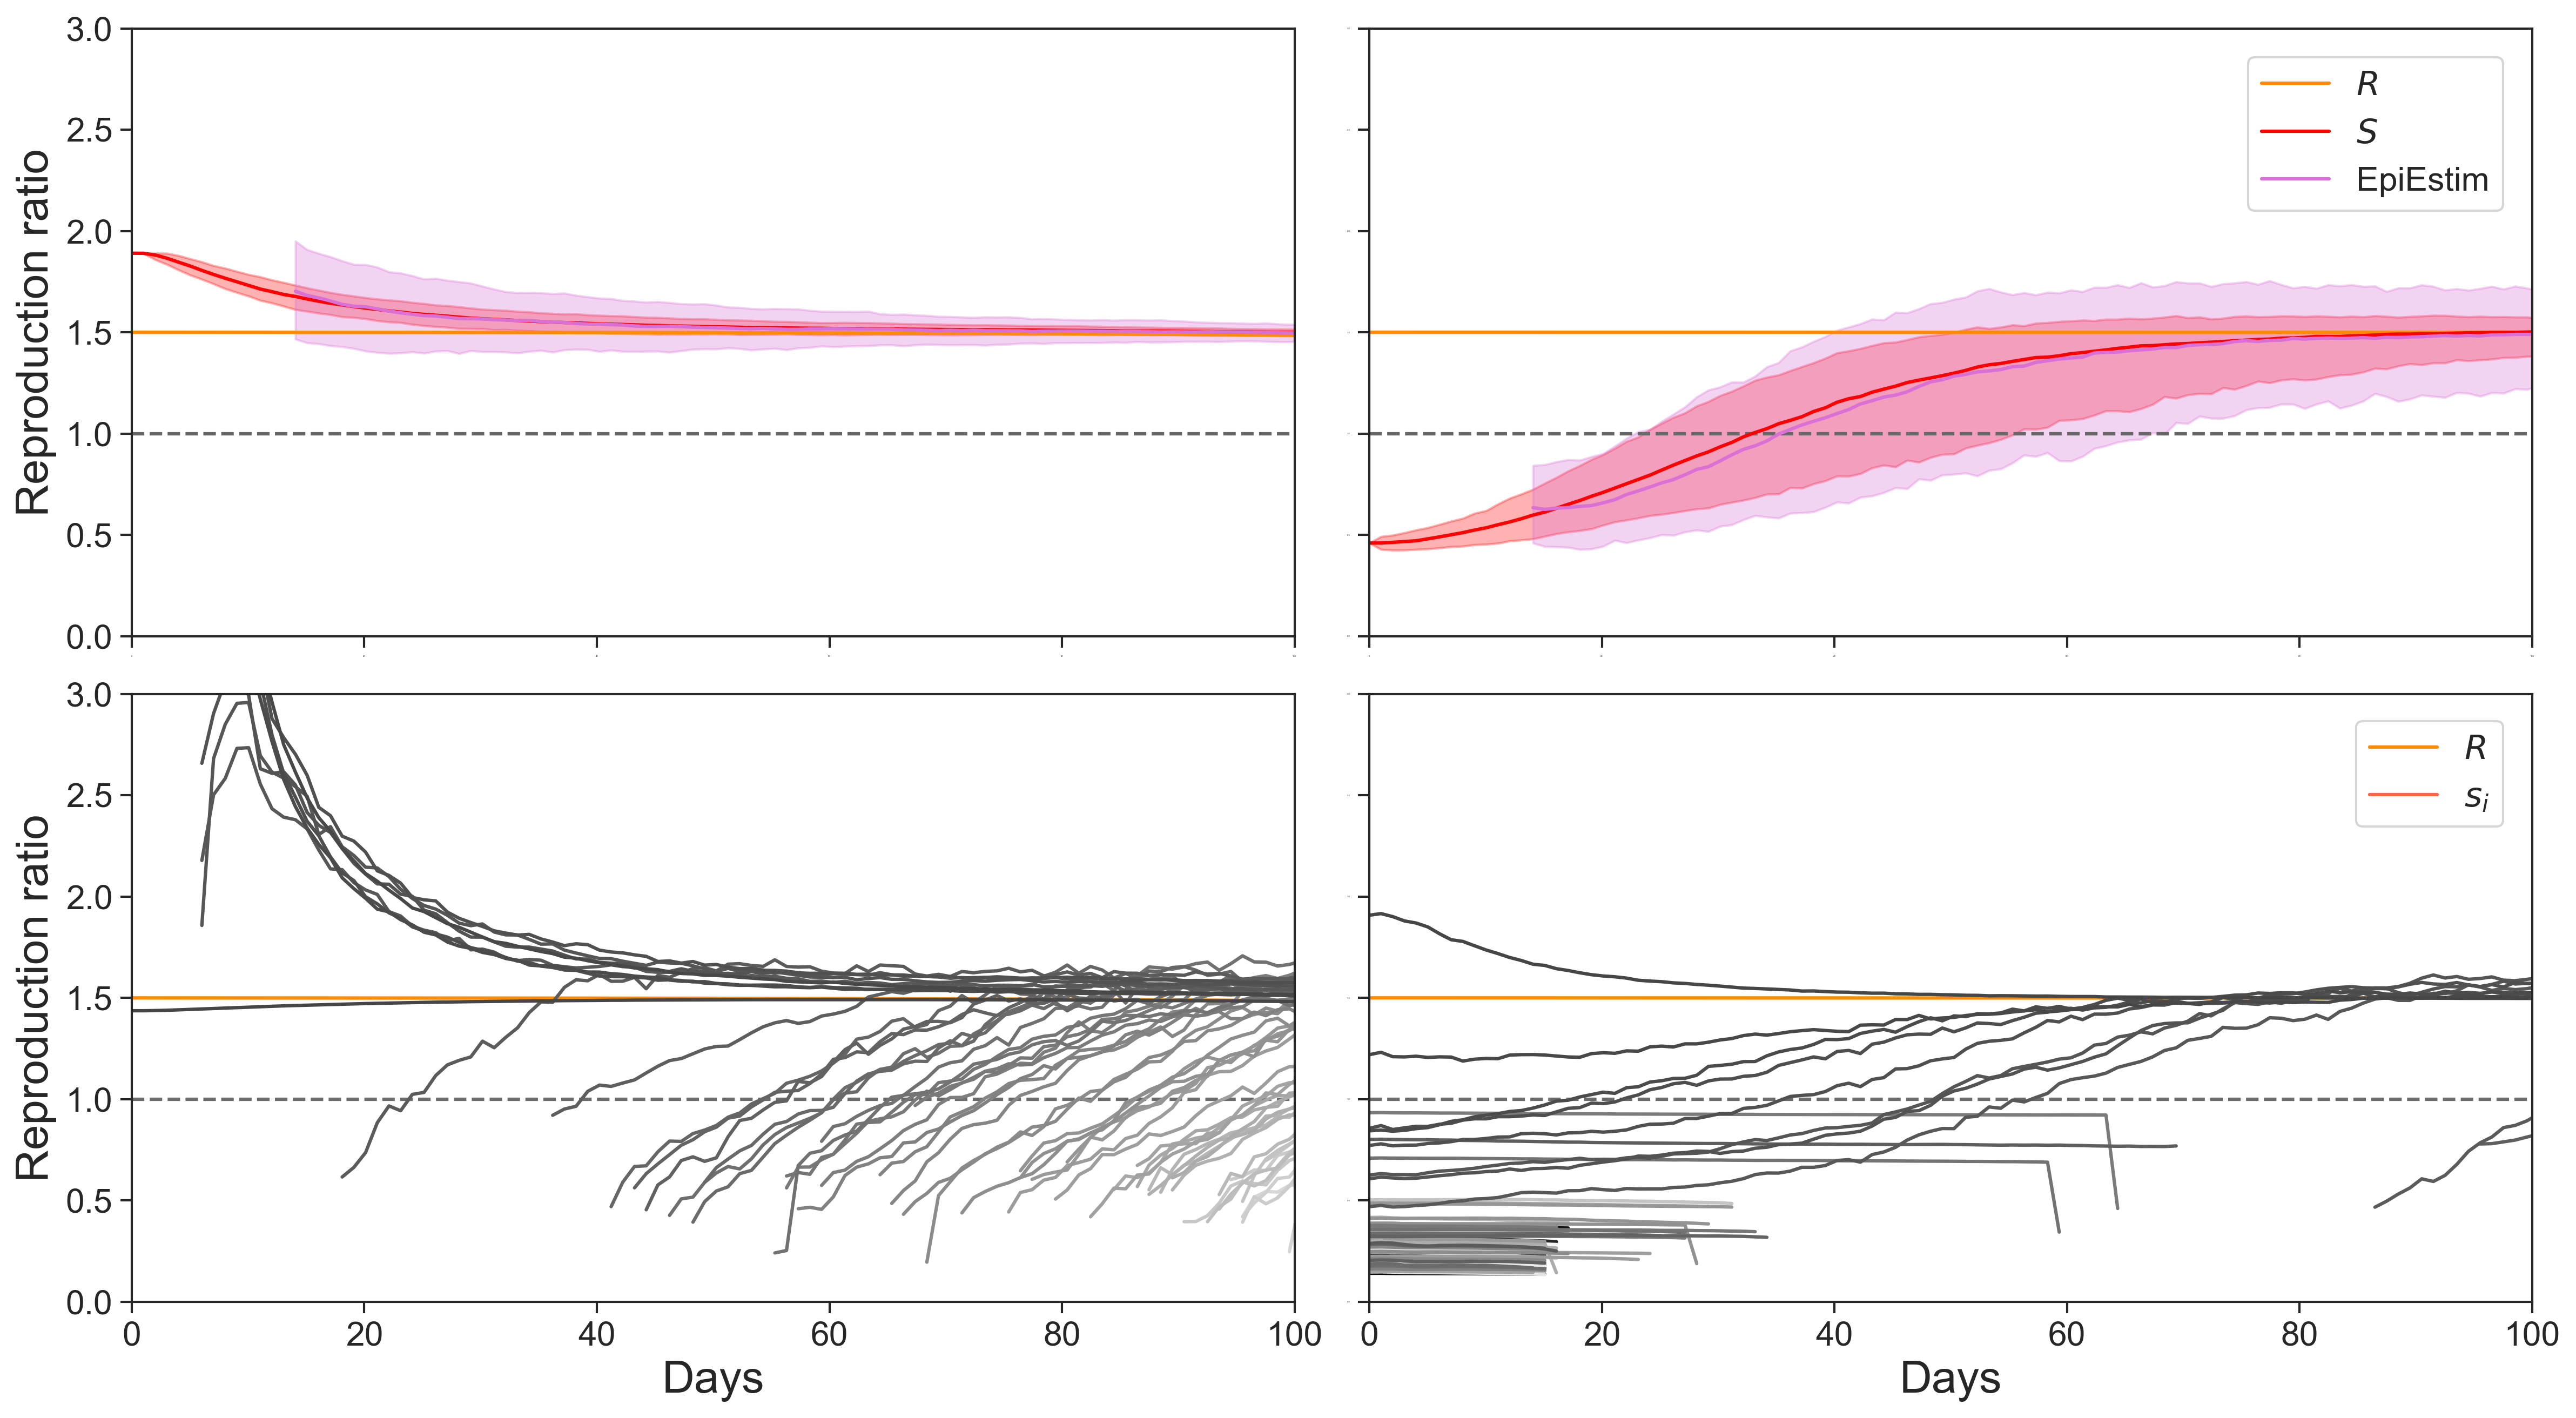

In [17]:
S_panel_plotter_Fig1(S_check,S_epi_check,s_check,max_w_=max_w,save=True,name='Fig1_together_grys_drkrng_July_w')

In [18]:
def S_vcorr_Fig4(S,S_proj,S_Epi,S_Epi_proj,dim1=1,dim2=2,proj=False,max_w_=max_w,end=[101,101],start=0,save=False,name='a',tit=None):
    
    fig,ax = plt.subplots(dim1,dim2,figsize=(16,5),dpi=300)
    #c=['gold','tab:blue','dimgrey','r','orchid','coral']#previous R: dimgrey
    c=['darkorange','tab:blue','dimgrey','r','orchid','coral']
    x=np.linspace(0,len(S[0,0]),len(S[0,0]))
    pref=params['beta']*(1-params['p_sc']+params['beta_I']*params['p_sc'])/params['mu']
    w1=pref*np.amax(np.linalg.eig(Q_2021_02_02)[0])
    fig.suptitle(tit,fontsize=20 )
    sh=14

    for i,a in enumerate (ax.reshape(-1)): #(1/(np.linalg.norm(max_v)**2))*
        m=pref*np.percentile(S[i],50,axis=0)
        CI=pref*np.array((np.percentile(S[i],2.5,axis=0),np.percentile(S[i],97.5,axis=0)))
        m_proj=pref*np.percentile(S_proj[i],50,axis=0)
        CI_proj=pref*np.array((np.percentile(S_proj[i],2.5,axis=0),np.percentile(S_proj[i],97.5,axis=0)))
        m_Epi=np.percentile(S_Epi[i],50,axis=0)
        CI_Epi=np.array((np.percentile(S_Epi[i],2.5,axis=0),np.percentile(S_Epi[i],97.5,axis=0)))
        m_Epi_proj=np.percentile(S_Epi_proj[i],50,axis=0)
        CI_Epi_proj=np.array((np.percentile(S_Epi_proj[i],2.5,axis=0),np.percentile(S_Epi_proj[i],97.5,axis=0)))
        mw=pref*np.percentile(max_w_[i],50,axis=0)
        CIw=pref*np.array((np.percentile(max_w_[i],2.5,axis=0),np.percentile(max_w_[i],97.5,axis=0)))
        a.axhline(1,0,1,color=c[2],linestyle='dashed',alpha=1)#,label=r'$\mathcal{R}_0=r[Q_0]$')
        a.plot(x[start:end[i]],mw[start:end[i]],label=r'$R$',color=c[0])
        a.fill_between(x[start:end[i]],CIw[0][start:end[i]],CIw[1][start:end[i]], color=c[0],alpha=.3)
        a.plot(x[start:end[i]],m[start:end[i]],label=r'$S$',color=c[3])
        a.fill_between(x[start:end[i]],CI[0][start:end[i]],CI[1][start:end[i]], color=c[3],alpha=.3)
        a.plot(x[start+sh:end[i]],m_Epi[start+(sh-5):end[i]-5],label='EpiEstim',color=c[4])
        a.fill_between(x[start+sh:end[i]],CI_Epi[0][start+(sh-5):end[i]-5],CI_Epi[1][start+(sh-5):end[i]-5], color=c[4],alpha=.3)
        if(proj==True):
            a.plot(x[start:end[i]],m_proj[start:end[i]],label=r'$S^{(v)}$',color='tab:blue')
            a.fill_between(x[start:end[i]],CI_proj[0][start:end[i]],CI_proj[1][start:end[i]], color='tab:blue',alpha=.3)
            a.plot(x[start+sh:end[i]],m_Epi_proj[start+(sh-5):end[i]-5],label=r'EpiEstim$^{(v)}$',color='lightsteelblue')#cornflowerblue
            a.fill_between(x[start+sh:end[i]],CI_Epi_proj[0][start+(sh-5):end[i]-5],CI_Epi_proj[1][start+(sh-5):end[i]-5], color='lightsteelblue',alpha=.3)
        a.tick_params(axis='x',labelsize=15)
        if i==0:
            a.tick_params(axis='y', labelsize=15)
            a.set_ylabel('Reproduction ratio',fontsize=20)
        else:
            a.tick_params(axis='y', labelsize=0)
        #a.grid(alpha=.7,axis='x')
        a.set_ylim([0,3])
        a.set_xlim([0,100])
        a.set_xlabel('Days',fontsize=20)
    #fig.supylabel('Values',fontsize=20)
    handles, labels = a.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2,bbox_to_anchor=(0.975, 0.915),bbox_transform=fig.transFigure, frameon=True,fontsize=15)#0.975,0.449/0.485/0.262
    fig.tight_layout()
    if (save==True):
        #fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/Fig1/'+str('/')+str(name))
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paper/Figure3.svg',bbox_inches='tight')
        fig.savefig('C:/Users/piero/Documents/PHD/eugenio/PLOTS/paper/Figure3.pdf',bbox_inches='tight')

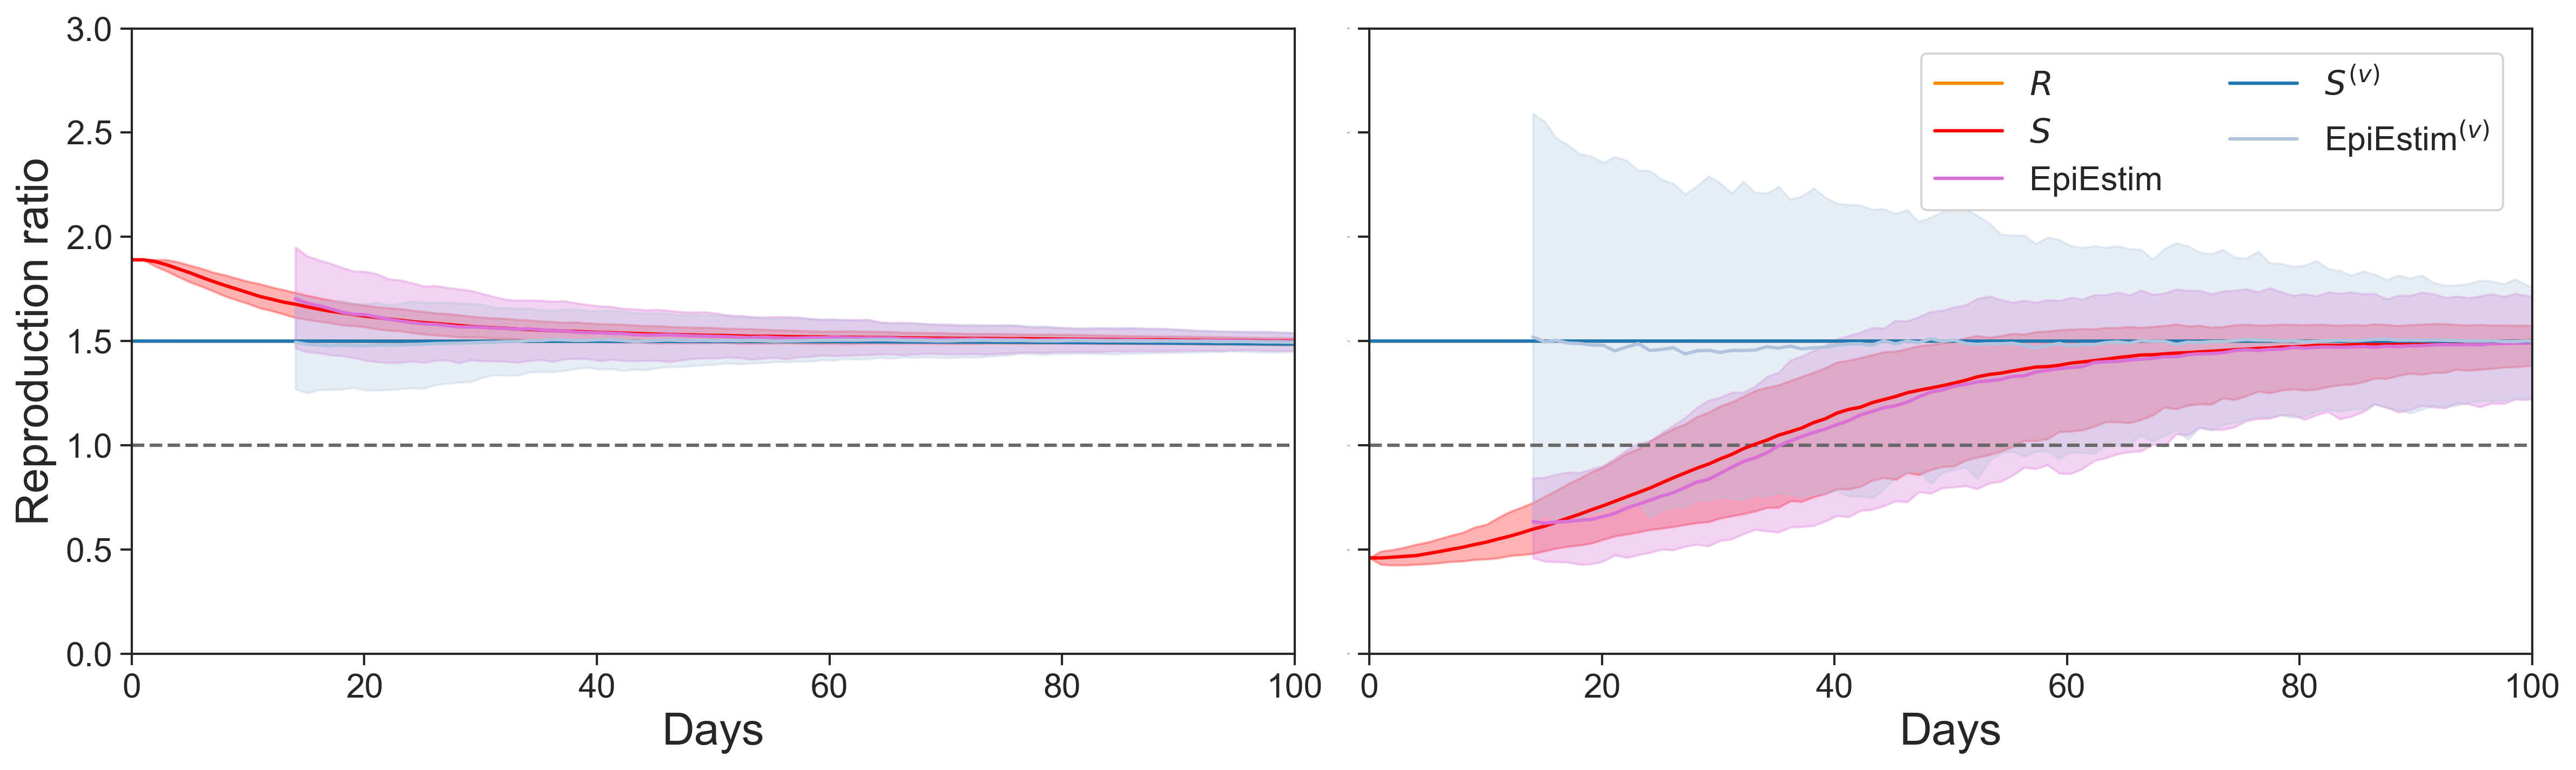

In [19]:
S_vcorr_Fig4(S_check,S_zproj_check,S_epi_check,S_epi_check_zproj,max_w_=max_w,proj=True,save=True,name='Fig4_hor_drkrng_July_w')